## XGBoost - eXtreme Gradient Boosting

XGBoost is an advanced implementation of gradient boosting algorithms. It uses a gradient boosting framework for building decision trees in a sequential manner, where
each new tree corrects errors made by previously trained trees. 
XGBoost has been optimized to deliver high performance and speed compared to other gradient boosting libraries. It can be used for both regression and classification problems (Chen & Guestrin, 2016). In our case, we will use it for classification, and since we have a rather large dataset, the performance and speed XGB provides is what we are looking for.

In [1]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss, mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from Helper.Data import loadData
import matplotlib.pyplot as plt

from Helper.Evaluate_XGBoostModel import evaluate_xgb_model
from Helper.Perform_CrossVal import perform_cross_validation
from Helper.Perform_GridSearch import perform_grid_search

pd.options.mode.chained_assignment = None

In [2]:
X_final, y, X_train, X_test, y_train, y_test, data, feature_columns, categorical_features,target_column, label_encoder = loadData()
X_final

X          Y  DayOfWeek_Friday  DayOfWeek_Monday  \
0      -122.426995  37.800873               0.0               0.0   
1      -122.438738  37.771541               0.0               0.0   
2      -122.403252  37.713431               0.0               0.0   
3      -122.423327  37.725138               0.0               0.0   
4      -122.371274  37.727564               0.0               0.0   
...            ...        ...               ...               ...   
395397 -122.431046  37.783030               0.0               1.0   
395398 -122.414073  37.751685               0.0               1.0   
395399 -122.389769  37.730564               0.0               1.0   
395400 -122.447364  37.731948               0.0               1.0   
395401 -122.403390  37.780266               0.0               1.0   

        DayOfWeek_Saturday  DayOfWeek_Sunday  DayOfWeek_Thursday  \
0                      0.0               0.0                 0.0   
1                      0.0               0.0                 0.0   
2                      0.0               0.0                 0.0   
3                      0.0               0.0                 0.0   
4                      0.0               0.0                 0.0   
...                    ...               ...                 ...   
395397                 0.0               0.0                 0.0   
395398                 0.0               0.0                 0.0   
395399                 0.0               0.0                 0.0   
395400                 0.0               0.0                 0.0   
395401                 0.0               0.0                 0.0   

        DayOfWeek_Tuesday  DayOfWeek_Wednesday  PdDistrict_BAYVIEW  ...  \
0                     0.0                  1.0                 0.0  ...   
1                     0.0                  1.0                 0.0  ...   
2                     0.0                  1.0                 0.0  ...   
3                     0.0                  1.0                 0.0  ...   
4                     0.0                  1.0                 1.0  ...   
...                   ...                  ...                 ...  ...   
395397                0.0                  0.0                 0.0  ...   
395398                0.0                  0.0                 0.0  ...   
395399                0.0                  0.0                 1.0  ...   
395400                0.0                  0.0                 0.0  ...   
395401                0.0                  0.0                 0.0  ...   

        Events_Clear  Events_Fog  Events_Fog-Rain  Events_Rain  \
0                1.0         0.0              0.0          0.0   
1                1.0         0.0              0.0          0.0   
2                1.0         0.0              0.0          0.0   
3                1.0         0.0              0.0          0.0   
4                1.0         0.0              0.0          0.0   
...              ...         ...              ...          ...   
395397           1.0         0.0              0.0          0.0   
395398           1.0         0.0              0.0          0.0   
395399           1.0         0.0              0.0          0.0   
395400           1.0         0.0              0.0          0.0   
395401           1.0         0.0              0.0          0.0   

        Events_Rain-Thunderstorm  Events_Thunderstorm  season_Autumn  \
0                            0.0                  0.0            0.0   
1                            0.0                  0.0            0.0   
2                            0.0                  0.0            0.0   
3                            0.0                  0.0            0.0   
4                            0.0                  0.0            0.0   
...                          ...                  ...            ...   
395397                       0.0                  0.0            0.0   
395398                       0.0                  0.0            0.0   
395399                       

### Encode 
In the preprocessing stage of our multi-class classification pipeline, we employ a crucial step of transforming categorical target variables into a numerical format. This transformation is essential for compatibility with XGBoost, a gradient boosting framework that requires numerical input to perform mathematical operations and optimizations integral to its learning algorithm (Chen & Guestrin,
2016).
XGBoost, like many machine learning algorithms, operates on numerical data to execute arithmetic operations, gradient calculations, and optimization procedures. These operations are not inherently
defined for categorical data, necessitating a transformation of categorical labels into a numerical representation (Bishop, 2006).
Specifically, for a multi-class classification problem, each unique categorical class label is assigned a unique integer value, a process known as label encoding. This procedure transforms the
categorical target variable into a format amenable to the mathematical computations required by XGBoost (Hastie, Tibshirani, & Friedman, 2009).
For a dataset with \(C\) unique classes, label encoding maps each class to a unique integer in the range \([0, C-1]\). This approach is both efficient and straightforward, ensuring that the transformed target variable retains the essential categorical information in a numerical format compatible with XGBoost's requirements (James, Witten, Hastie, & Tibshirani, 2013).
Upon transformation, XGBoost utilizes the numerical labels to compute a multi-class log loss (cross-entropy loss) when the `multi:softprob` or `multi:softmax` objective function is specified.
This loss function quantifies the difference between the predicted probabilities and the actual class labels, guiding the model's learning process (Friedman, 2001).
The transformation of categorical data into numerical form is supported by the foundational principles of statistical learning, which emphasize the necessity of numerical representation for the application of mathematical models to data analysis and prediction tasks (Bishop, 2006; Hastie, Tibshirani, & Friedman, 2009). 
Furthermore, research by Chen and Guestrin (2016) on XGBoost highlights
the effectiveness of gradient boosting machines for various tasks, including multi-class classification, when data is appropriately preprocessed and encoded.
Data transformation step is not merely a technical requirement but a scientifically grounded practice that enhances the ability of XGBoost to accurately model and predict outcomes in multi-class classification settings.
By converting categorical labels into a numerical format, we align our dataset with the underlying mathematical framework of machine learning algorithms, facilitating efficient and effective model training and prediction.

In [4]:
#initialize coder and classifier
xgb_clf = XGBClassifier(objective="multi:softprob",use_label_encoder=False, eval_metric='mlogloss')

### Preliminary Testing
Preliminary testing of machine learning models is crucial during the development phase, providing early insights into model performance and setting the stage for further optimizations.
These tests, often conducted via cross-validation this allows us to assess the robustness and generalizability of our models before committing extensive resources to fine-tuning and evaluation. Cross-validation, a common method for preliminary testing, is a powerful tool for assessing model quality.
It splits the data into multiple subsets and performs repeated training and testing runs to ensure the model performs reliably on unseen data (Kohavi, 1995).
This method helps avoid overfitting and provides an unbiased estimate of model performance.
In our research, we found out that scientific studies have underscored the importance of early model evaluation in the development process.
It allows for the quick identification of inefficient approaches, focusing resources on more promising models (Guyon et al., 2002). 
We know that one of our project tasks is to implement hyperparameters and improve the model.
Therefore, we know that our model may have weaknesses at the beginning and is not the best, but we still want to go one step further and train an early model to gain more insights.
Furthermore, research highlights the significance of selecting appropriate metrics for performance evaluation, as they can significantly influence the direction of development and the assessment of model quality (Powers, 2011).
We do this because in practice, preliminary tests support the iterative improvement of models by identifying strengths and weaknesses at early stages of development. This approach promotes efficient use of resources and ultimately leads to more powerful and reliable machine learning models.

In [5]:
from sklearn.model_selection import cross_validate

# Scoring-Kriterien definieren
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# Kreuzvalidierung mit mehreren Metriken
cv_results = cross_validate(xgb_clf,X_final, y, cv=4, scoring=scoring, return_train_score=True)

# Ergebnisse ausgeben
for metric in scoring.keys():
    print(f"Average {metric}: {np.mean(cv_results[f'test_{metric}']) * 100:.4f}%")
    print(f"Standard deviation {metric}: {np.std(cv_results[f'test_{metric}']) * 100:.4f}%")

# Prüfen nach Overfitting
for metric in scoring.keys():
    test_std = np.std(cv_results[f'test_{metric}'])
    train_std = np.std(cv_results[f'train_{metric}'])
    print(f"Difference in std between train and test {metric}: {(train_std - test_std) * 100:.4f}%")

Average accuracy: 49.1424%
Standard deviation accuracy: 1.8019%
Average f1_macro: 32.6813%
Standard deviation f1_macro: 3.0414%
Average roc_auc_ovr: 71.7766%
Standard deviation roc_auc_ovr: 0.6514%
Difference in std between train and test accuracy: -1.3382%
Difference in std between train and test f1_macro: -2.0587%
Difference in std between train and test roc_auc_ovr: -0.2399%


In [6]:
# Training the classifier
xgb_clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Predicting the probabilities for the test set
y_pred_proba = xgb_clf.predict_proba(X_test)

# Calculation of various metrics
# We use the “weighted” parameter because this takes imbalances into account
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# ROC-AUC Score requires binarized labels for multiclass classification, so we need to transform them beforehand using the LabelBinarizer()
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binarized = lb.transform(y_test)
y_pred_binarized = lb.transform(y_pred)

roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovo', average='weighted')
logloss = log_loss(y_test, y_pred_proba)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}%")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.5281
F1-score: 0.4683%
ROC-AUC Score: 0.7493


### Feature Importance
Feature importance refers to techniques used to quantify the contribution of each feature in a dataset to the predictive power of a model.
It provides insights into the data's underlying structure, highlights the features that contribute most to the model's predictions, and can lead to more efficient and interpretable models.
In this example, we use it for XGBoost, i.e. decision tree models including Random Forests and other Gradient Boosting Machines.
These algorithms use measures such as Gini importance or mean impurity decrease to indicate feature importance. These methods calculate how much each feature contributes to the decision-making process in trees (Breiman, 2001; Chen & Guestrin, 2016).

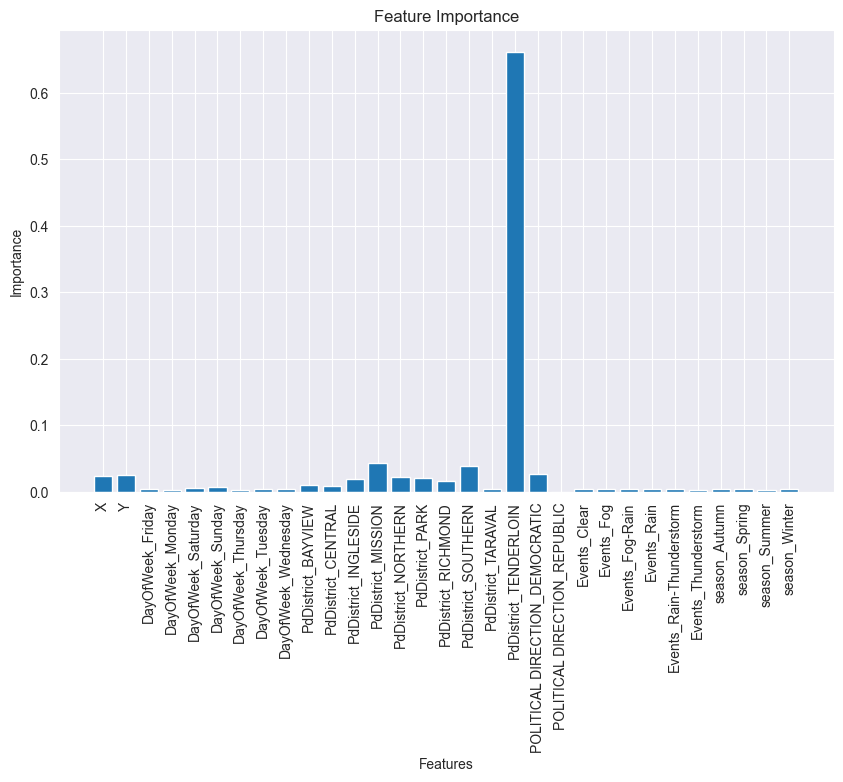

In [8]:
# extract feature importance
importance = xgb_clf.feature_importances_
feature_names = X_train.columns.tolist()

# plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), feature_names, rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

#### Feature Importance - Conclusion
This bar chart illustrates the feature importance as determined by a machine learning model. Each bar represents a different feature from our dataset, and the height of the bar indicates how important that feature is in terms of the model's decision-making process.
As you can see, most features appear to have a relatively low importance score, contributing a small amount to the predictions. However, there is one feature that stands
out significantly above the rest. It has an importance score of over 0.6, making it the most influential feature by a large margin. This feature is likely a key predictor
in our model, and any changes to this feature could have a substantial impact on the model's output.
The lower-ranking features, while they do contribute to the model, have a much smaller effect on the overall predictions. These might represent more nuanced patterns in
the data or may be providing some marginal improvement in the model's accuracy.
For the most effective model, we should focus on the high-importance features during feature engineering and model tuning. Also, it's worth investigating why the
dominant feature is so influential.
This singular feature appears to be significantly more influential in the model's predictions than all others. Such a disparity in feature importance suggests that the model's decisions are heavily reliant on this one attribute, which could be a concern for several reasons including **over-reliance on a single feature** and **overfitting**.
It's interesting to note the spread of importance across the features. For example, 'DayOfWeek' features have some variation, but none come close to the importance of
our top feature. The 'PdDistrict' features also show variation in importance, with some districts being more relevant than others.
The political direction features also show a stark contrast—'POLITICAL DIRECTION_DEMOCRATIC' seems to be far more important than 'POLITICAL DIRECTION_REPUBLIC.' This
could suggest a significant difference in outcomes based on these political directions, at least as far as the model has learned from the data.
Lastly, the 'Events' and 'season' features have very low importance scores. This indicates that, in the context of our model, weather events and seasons do not play a
major role in predictions, which might be surprising depending on the domain we're analyzing.
Overall, this feature importance chart provides us with valuable insights into which factors are driving the model's predictions and which may be less critical.
This can help us streamline the model and potentially improve its performance by focusing on the most impactful features.

### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is an effective method for feature selection that can enhance the performance of predictive models in statistics and machine
learning. This technique aims to identify the most predictive features by successively removing the least important ones. The process starts with the complete set of
features and iteratively eliminates the least significant feature, based on the model criterion chosen, until a predetermined number of features is reached or the model
performance reaches an optimum.

A key aspect of RFE is its ability to derive feature importance directly from the coefficients of models that provide intrinsic feature weightings, such as linear models
and Support Vector Machines (Guyon et al., 2002). By incorporating Cross-Validation (CV) into the RFE process, known as RFECV, the robustness of feature selection is
further enhanced by accounting for the variability of model performance across different data splits (Kohavi, 1995).

The application of RFE can offer value across numerous domains by not only improving model performance through the reduction of overfitting and enhancing the
generalizability. It is also contributing to the interpretability of the models by highlighting the most relevant features.
Therefore, we want to combine it with the feature importance analyses which only provides a ranking based on the contribution of each feature to the model's performance.

Optimal number of features: 10
Selected features and their rankings:
X: Rank 1
Y: Rank 1
DayOfWeek_Friday: Rank 11
DayOfWeek_Monday: Rank 18
DayOfWeek_Saturday: Rank 7
DayOfWeek_Sunday: Rank 6
DayOfWeek_Thursday: Rank 20
DayOfWeek_Tuesday: Rank 17
DayOfWeek_Wednesday: Rank 9
PdDistrict_BAYVIEW: Rank 3
PdDistrict_CENTRAL: Rank 2
PdDistrict_INGLESIDE: Rank 1
PdDistrict_MISSION: Rank 1
PdDistrict_NORTHERN: Rank 1
PdDistrict_PARK: Rank 1
PdDistrict_RICHMOND: Rank 1
PdDistrict_SOUTHERN: Rank 1
PdDistrict_TARAVAL: Rank 4
PdDistrict_TENDERLOIN: Rank 1
POLITICAL DIRECTION_DEMOCRATIC: Rank 1
POLITICAL DIRECTION_REPUBLIC: Rank 22
Events_Clear: Rank 14
Events_Fog: Rank 12
Events_Fog-Rain: Rank 5
Events_Rain: Rank 15
Events_Rain-Thunderstorm: Rank 8
Events_Thunderstorm: Rank 19
season_Autumn: Rank 16
season_Spring: Rank 13
season_Summer: Rank 21
season_Winter: Rank 10


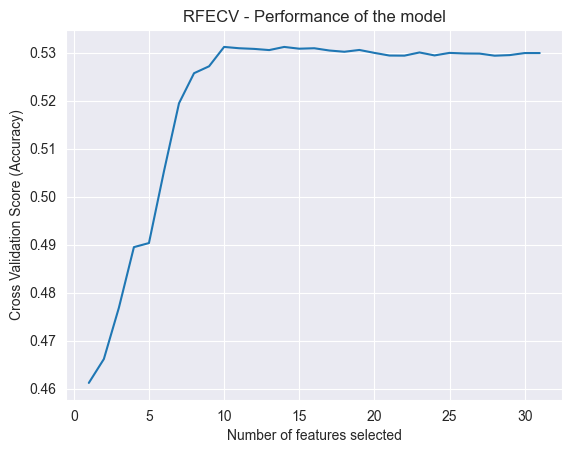

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
# initialise RFECV 
cv_strategy = StratifiedKFold(n_splits=5)
rfecv = RFECV(estimator=xgb_clf, step=1, cv=cv_strategy, scoring='accuracy')

# RFECV fit
rfecv.fit(X_train, y_train)

# print optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)

# Extracting the feature names based on RFECV support
#selected_features = X_train.columns[rfecv.support_]

# Output of the selected feature names and their rankings
print("Selected features and their rankings:")
for rank, feature in zip(rfecv.ranking_, X_train.columns):
    print(f"{feature}: Rank {rank}")

# Plot
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross Validation Score (Accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title('RFECV - Performance of the model')
plt.show()


#### Recursive Feature Elimination - Conclusion

From the plot, we can observe that as the number of features initially increases, there is a sharp increase in the cross-validation score. 
This suggests that adding features initially leads to a substantial improvement in model accuracy. 
However, after selecting 10 features, the cross-validation score plateaus, indicating that adding more features beyond this point does not significantly improve the
model's performance.
Furthermore the rankings provided alongside the image indicate the relative importance of each feature as determined by the RFECV process. The features with a rank of 1
are deemed most important, and they include 'X', 'Y', and several 'PdDistrict' features, among others. On the other hand, features like 'DayOfWeek_Thursday' and
'season_Summer' have higher rankings, such as 20 and 21 respectively, suggesting they are less important for the model's predictive capability.
The optimal number of features, according to the RFECV, is **10**. This optimal subset includes the most relevant features that contribute to the highest
cross-validation score obtained, which is slightly above 0.53. Features with a lower rank are more likely to be selected in the optimal feature set, while those with a
higher rank (above 10 in this case) are deemed less important and are likely excluded from the optimal subset.
This analysis gives us a more detailed look into the feature then our feature importance part which we discussed earlier.

### Confusion Matrix
The confusion matrix is a fundamental and highly informative tool used in the evaluation of classification models. 
It presents a detailed breakdown of the model's predictions, allowing us to see not just the overall accuracy but also how well the model distinguishes between different classes. 
This matrix is particularly useful in highlighting the strengths and weaknesses of a model across various categories.

Why is it important for us?
First of all, the **model performance** as the confusion matrix provides a comprehensive overview of how well the model performs across different classes, highlighting potential biases towards certain categories (Provost & Fawcett, 2013).
Secondly, the **Error Analysis**, which allows us to identify the specific areas where the model makes errors, such as B. high rates of false positives or false negatives. Practitioners can focus their efforts on improving model performance in these areas (Fawcett, 2006).
Then we have the **dataset insight**. This allows us to see if we have imbalanced classes, accuracy alone can be misleading. The confusion matrix helps in understanding the model's performance in predicting minority classes (He & Garcia, 2009).
And finally, the matrix helps us in **decision making**. It helps us understand the trade-offs between different types of errors and can influence decision making in critical applications where the cost of false positives can differ significantly from that of false negatives.

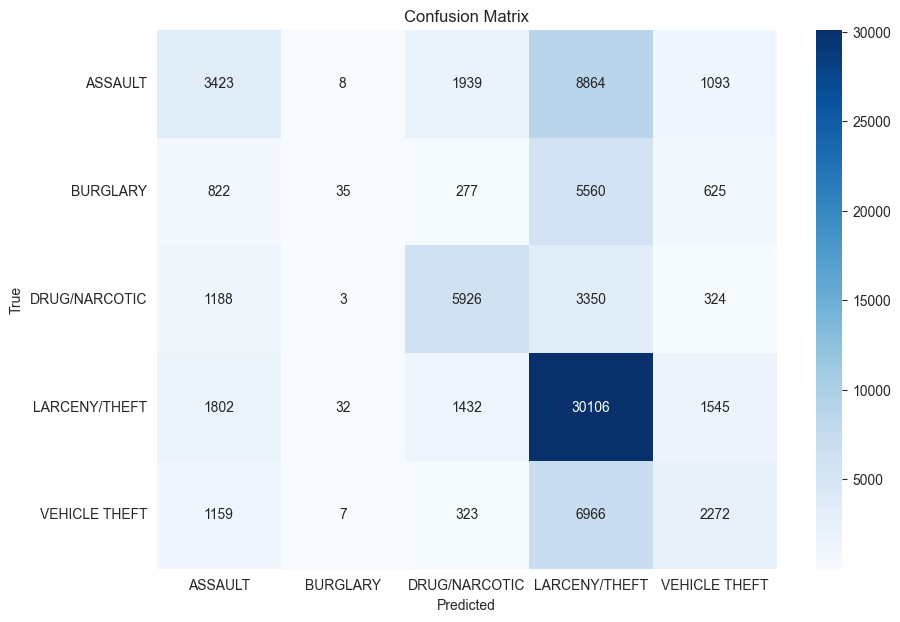

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_test_names = label_encoder.inverse_transform(y_test)

# Nun können Sie `y_test_names` verwenden, um die Konfusionsmatrix und die ROC-Kurven mit den tatsächlichen Klassennamen zu plotten

# Für die Konfusionsmatrix
cm = confusion_matrix(y_test_names, label_encoder.inverse_transform(y_pred)) # Annahme, dass y_pred die Vorhersagen sind
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Confusion Matrix - Conclusion
First we look at the diagonal cells as those represent the number of correct predicitons for each class (TP).
For instance, there are 3,423 instances where "ASSAULT" was correctly predicted as "ASSAULT", and 5,926 instances where "DRUG/NARCOTIC" was correctly predicted as such.
Next we can look horizontally for each true class, the non-diagonal cells represent the instances that were incorrectly classified as some other class. For example, 1,939 true "ASSAULT" cases were falsely predicted as "DRUG/NARCOTIC".
Vertically, for each predicted class, the non-diagonal cells show the instances of other classes incorrectly predicted as that class. For example, there are 1,802 instances where "LARCENY/THEFT" was incorrectly predicted as "ASSAULT".
If we look at this class-wise, we can see that "LARCENY/THEFT" has the highest number of correct predictions with 30,106 instances, suggesting the model is particularly
good at identifying this class.
"BURGLARY" has the lowest number of correct predictions with only 35 instances, indicating the model struggles to correctly identify this class.
"ASSAULT" and "VEHICLE THEFT" have a considerable number of instances incorrectly classified as "LARCENY/THEFT", which could suggest that the model is biased towards
predicting "LARCENY/THEFT" more often, or that there are characteristics of "LARCENY/THEFT" that are frequently confused with those crimes.
Our conclusion is that the model shows a strong predictive performance for "DRUG/NARCOTIC" and "LARCENY/THEFT".
There is a notable confusion between "ASSAULT" and "LARCENY/THEFT", as well as between "VEHICLE THEFT" and "LARCENY/THEFT".
For "BURGLARY", the model's predictive performance is poor, which could be due to a variety of factors such as fewer training samples, less distinctive features, or
similarities with other classes that confuse the model.

### ROC - Curve
The ROC curve provides a comprehensive visualization of a classifier's performance across various threshold settings, not just a single point estimate. This is crucial
because it allows us to assess the trade-offs between the true positive rate (sensitivity) and the false positive rate (1-specificity) at different thresholds (Fawcett,
2006).
This tool allows us to compare the performance of different classifiers on the same problem and also the prediction of different outcomes of the same classifier.
By plotting the ROC curves of multiple models, we can visually identify which model better discriminates between the classes, as the one closer to the top-left corner
of the plot is generally considered superior (Hanley and McNeil, 1982).
Since we have a rather imbalanced dataset, a ROC curve is particularly useful to deal with this problem because the metric used to generate the curve is not affected by
the class distribution. This makes ROC analysis an appropriate tool for evaluating models on imbalanced problems (He & Garcia, 2009).
Furthermore, we use the Area under the curve (AUC) as a performance metric as it is widely used because it is an aggregate measure of performance across all possible classification thresholds (Bradley, 1997).


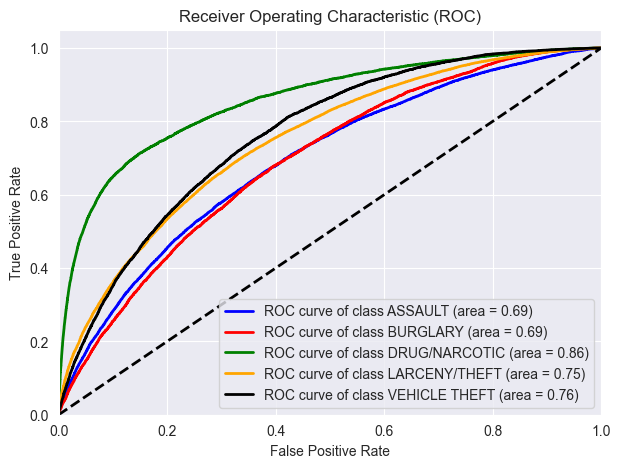

In [11]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange', 'black'])

# plot ROC
plt.figure(figsize=(7, 5))
for i, color in zip(range(n_classes), colors):
    # Ersetzen von `i` durch `label_encoder.classes_[i]` für die Klassennamen
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### Precision-Recall Curve

 The Precision-Recall (PR) curve is an essential tool for assessing the effectiveness of classifiers, especially in situations with imbalanced datasets.
 Precision and Recall are two metrics used to evaluate the quality of a classification model. Precision indicates the proportion of instances classified as
 positive that are actually positive, while Recall indicates the proportion of actual positive instances that were classified as positive (Davis & Goadrich,
 2006). 
 The PR curve plots these two metrics in a coordinate system, with Recall on the X-axis and Precision on the Y-axis.
 The PR curve is particularly important in areas where the costs of false positives are very different or when the classes are imbalanced as in our project.
 In such cases, the PR curve can provide more detailed insights into the model's performance than other metrics, such as the ROC curve (Receiver Operating
 Characteristic Curve). 
 The area under the PR curve (AUC-PR) can be considered a measure of the overall performance of the classification model (Saito & Rehmsmeier, 2015).

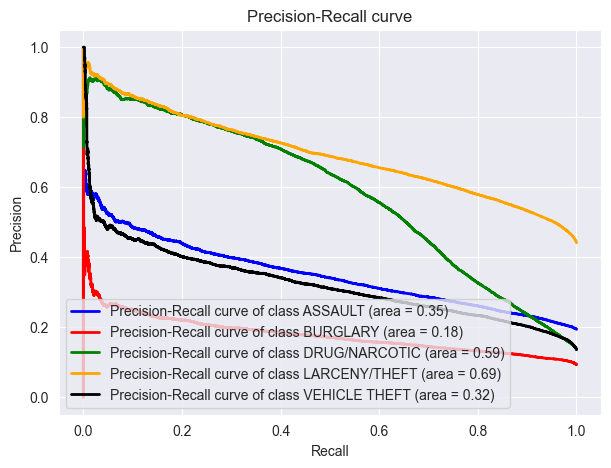

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = y_test_binarized.shape[1]
precision = dict()
recall = dict()
average_precision = dict()

colors = cycle(['blue', 'red', 'green', 'orange', 'black'])

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i],
                                                        y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])

# plot
plt.figure(figsize=(7, 5))
for i, color in zip(range(n_classes), colors):
    # Replace 'i' with 'label_encoder.classes_[i]' to use the actual class names
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


#### Precision-Recall Curve - Conclusion
As we can see the curves generally start with high precision at the left (when recall is low), which typically decreases as recall increases. This is expected because as the model tries to cover more of the actual positive instances (increasing recall), it is also likely to incorrectly label more negative instances as positive (decreasing precision).The closer the curve follows the left-hand border and then the top border of the Precision-Recall space, the more precise the classifier is.
A higher area under the curve (AUC) represents both high recall and high precision, where high precision relates to a low false-positive rate, and high recall relates to a low false-negative rate. That said we can look into the different classes:

- **ASSAULT (Red Curve)**: With an AUC of 0.35, the model has moderate ability to distinguish between positive and negative instances of assault. A lower AUC indicates room for improvement, especially in the context of precision.
- **BURGLARY (Green Curve)**: This curve has an AUC of 0.18, suggesting the model performs poorly in identifying burglary instances, with both precision and recall being low. This is the least performing class among those presented.
- **DRUG/NARCOTIC (Dark Blue Curve)**: The AUC here is 0.59, which is relatively higher compared to the other classes. This indicates that the model is better at identifying drug/narcotic-related instances, maintaining a balance between precision and recall.
- **LARCENY/THEFT (Light Blue Curve)**: The AUC of 0.69 is the highest among the curves, showing that the model has a relatively high precision across different levels of recall for larceny/theft cases.
 - **VEHICLE THEFT (Orange Curve)**: With an AUC of 0.32, the model's performance on vehicle theft is similar to that for assault, indicating that it could be improved

To summarize, the model is best at identifying "LARCENY/THEFT" and performs worst at "BURGLARY". For this model, improving the precision for "BURGLARY" could be a key focus, as it has the lowest AUC, indicating a higher rate of false positives and false negatives. We did observe this in our other tests as well.
The curves provide insights into how the threshold can be adjusted to increase either precision or recall, depending on which is more important for the specific
application of the model.

### The Necessity of Applying GridSearchCV in Model Optimization

The process of developing a predictive model involves not only selecting an appropriate algorithm but also fine-tuning its hyperparameters to optimize performance.
GridSearchCV, a systematic approach for parameter tuning, plays a pivotal role in identifying the most effective combinations of hyperparameters for a given model.
This method systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance. 
The necessity of employing GridSearchCV can be substantiated by several key factors.

GridSearchCV enables a comprehensive exploration of the parameter space, ensuring that the selected model is not just a product of arbitrary parameter choices but is instead optimized based on empirical evidence. This exhaustive search guarantees that the model's potential is fully realized by examining various permutations and combinations of parameters (Bergstra & Bengio, 2012).
By meticulously searching through the parameter space, GridSearchCV often uncovers hyperparameter settings that significantly enhance model performance compared to the default settings. This optimization process is crucial for complex datasets where the optimal model configuration is not intuitively obvious (Claesen & De Moor, 2015).
The selection of hyperparameters has a profound impact on the **bias-variance tradeoff**.
GridSearchCV assists in finding a balance, thereby reducing the risk of overfitting or underfitting. This balance is crucial for achieving generalizable model performance across unseen data (James et al., 2013).
Employing GridSearchCV adds **rigor and reproducibility** to the model development process. By documenting the explored parameter space and the performance of each combination researchers and practitioners provide a transparent account of the optimization process, facilitating replication and verification of the results (Varoquaux et al., 2015).

Therefore, we use GridSearchCV with the grid parameters specified in the code to find out which parameters could be the best.
However, it is also the case that parameters that do not appear in the array could be better.
But we select these and no more because the calculation is quite time-consuming and resource-intensive.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

# GridSearchCV-Initialisierung
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=4, n_jobs=-1)

# Suche nach den besten Parametern
grid_search.fit(X_train, y_train)

# Scores
print(f"Best Parameter: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_ * 100:.2f}%")


### Parameters

**'learning_rate': 0.2**: The learning rate determines how quickly or slowly a model learns from the errors in the training data. A learning rate of 0.2 is relatively high, meaning the model will converge faster, but there is a risk of it overshooting the optimum. For complex data sets, a higher learning rate can result in faster, but potentially less precise, adjustments.

**'max_depth': 5**: The maximum depth of a tree limits how detailed the model can learn the data structures. A depth of 5 is a compromise between the model's ability to recognize patterns in the data and the risk of overfitting. It allows for some complexity in the model predictions without diving too deeply into the data.

**'n_estimators': 300**: This number indicates how many trees to build in the ensemble model. 300 trees means the model tries to learn from the errors of 299 previous trees to improve predictions. A higher number of estimators can improve model performance, but also leads to longer training time and increased risk of overfitting if not controlled by other measures.

**'subsample': 1.0**: This means that the model uses all available data when training each tree instead of taking a sample. This can improve performance if the training data is diverse and representative, but also runs the risk of overfitting since each tree sees exactly the same data.

 **'Accuracy = 52.73%'**: This number indicates the best accuracy achieved by the model using the hyperparameters mentioned above. An accuracy of just over 50% suggests that the model is only slightly
 better than random guessing, assuming a binary classification task. However, for multiclass classification as in our project or with a very balanced data set, this might represent acceptable
 performance.

In [ ]:
best_params = grid_search.best_params_
best_xgb_clf = XGBClassifier(**best_params, objective="multi:softprob",use_label_encoder=False, eval_metric='mlogloss')
best_xgb_clf.fit(X_train, y_train)

y_pred = best_xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, best_xgb_clf.predict_proba(X_test), multi_class='ovo', average='weighted')

print(f"Accuracy on test data: {accuracy:.4f}%")
print(f"F1-score on test data: {f1:.4f}%")
print(f"ROC-AUC on test data: {roc_auc:.4f}")

TODO: 
1. standard modell trainieren mit angepassten parametern (auswerten)
2. FEATURES anpassen 
3. feature angepasstes modell nochmal trainieren ohne parameter (auswerten)
4. feature angepasstes modell gridsearch cv 
5. feature angepasstes modell mit angepassten parametern trainieren (auswerten)

In [ ]:
# Idee, das Feature mit dem höchsten Score entfernen wir, um zu überpüfen, ob sich Änderungen im Modell feststellen

X_train = X_train.drop(columns=['PdDistrict_TENDERLOIN'])
X_test = X_test.drop(columns=['PdDistrict_TENDERLOIN'])

In [ ]:
xgb_clf = XGBClassifier(objective="multi:softprob",use_label_encoder=False, eval_metric='mlogloss')
results = perform_cross_validation(xgb_clf, X_train, y_train)

for key, value in results.items():
 print(f"{key}: {value:.2f}%")

In [ ]:
 xgb_clf, accuracy, f1, roc_auc = evaluate_xgb_model(X_train, y_train, X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}%")
print(f"ROC-AUC Score: {roc_auc:.4f}")
importance = xgb_clf.feature_importances_
feature_names = X_train.columns.tolist()

# Feature Importance plotten
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), feature_names, rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
best_params, best_accuracy = perform_grid_search(X_train, y_train)

In [ ]:
xgb_clf, accuracy, f1, roc_auc = evaluate_xgb_model(X_train, y_train, X_test, y_test, best_params)
print(f"Accuracy on test data: {accuracy:.4f}%")
print(f"F1-score on test data: {f1:.4f}%")
print(f"ROC-AUC on test data: {roc_auc:.4f}")

# References:

- T. Chen & C. Guestrin (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.
- C.M. Bishop (2006). Pattern Recognition and Machine Learning. Springer.
- T. Hastie, R. Tibshirani, & J. Friedman (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Series in Statistics.
- G. James, D. Witten, T. Hastie, & R. Tibshirani (2013). An Introduction to Statistical Learning: with Applications in R. Springer Texts in Statistics.
- J.H. Friedman (2001). Greedy Function Approximation: A Gradient Boosting Machine. The Annals of Statistics.
- Guyon, I., Weston, J., Barnhill, S., & Vapnik, V. (2002). Gene selection for cancer classification using support vector machines. Machine Learning, 46(1-3), 389-422.
- Kohavi, R. (1995). A study of cross-validation and bootstrap for accuracy estimation and model selection. IJCAI'95: Proceedings of the 14th international joint conference on Artificial intelligence, 2(12), 1137-1145.
- Databasecamp. (2023) https://databasecamp.de/statistik/f1-score
- Davis, J., & Goadrich, M. (2006). The relationship between Precision-Recall and ROC curves. In Proceedings of the 23rd international conference on Machine learning (pp. 233-240).
- Saito, T., & Rehmsmeier, M. (2015). The Precision-Recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets.
- Kohavi, R. (1995). A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection. International Joint Conference on Artificial Intelligence.
- Guyon, I., Weston, J., Barnhill, S., & Vapnik, V. (2002). Gene Selection for Cancer Classification using Support Vector Machines. Machine Learning, 46(1-3), 389-422.
- Powers, D.M.W. (2011). Evaluation: From Precision, Recall and F-Factor to ROC, Informedness, Markedness & Correlation. Journal of Machine Learning Technologies, 2(1), 37-63.
- Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. Journal of Machine Learning Research, 13(Feb), 281-305.
- Claesen, M., & De Moor, B. (2015). Hyperparameter search in machine learning. arXiv preprint arXiv:1502.02127
- James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning. Springer.
- Varoquaux, G., Buitinck, L., Louppe, G., Grisel, O., Pedregosa, F., & Mueller, A. (2015). Scikit-learn: Machine learning without learning the machinery. GetMobile: Mobile Computing and Communications, 19(1), 29-33.
- Scikit-learn (2024) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
- Yellowbrick (2024) https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html
- Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5-32.
- Bradley, A. P. (1997). The use of the area under the ROC curve in the evaluation of machine learning algorithms. Pattern Recognition, 30(7), 1145-1159.
- Fawcett, T. (2006). An introduction to ROC analysis. Pattern Recognition Letters, 27(8), 861-874.
- He, H., & Garcia, E. A. (2009). Learning from imbalanced data. IEEE Transactions on Knowledge and Data Engineering, 21(9), 1263-1284.